# Melbourne Housing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def eval_preds(y_true_log, y_pred_log):
    #Valuta RMSE e MAE sulla scala reale (esponenziale del log).
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

def group_rare_categories(df, col, threshold=0.01):
    #Raggruppa le categorie rare in 'Other'.
    freq = df[col].value_counts(normalize=True)
    rare = freq[freq < threshold].index
    df[col] = df[col].replace(rare, 'Other')
    return df

In [3]:
df = pd.read_csv('Melbourne_housing.csv')

C:\Users\Rosy\AppData\Local\Temp\ipykernel_5184\1901315617.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Melbourne_housing.csv')


In [4]:
df.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longtitude,Regionname,Propertycount,ParkingArea,Price
0,Abbotsford,68 Studley St,2,h,SS,Jellis,3/9/2016,2.5,3067.0,2.0,...,126.0,inf,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0,Carport,NaN
1,Airport West,154 Halsey Rd,3,t,PI,Nelson,3/9/2016,13.5,3042.0,3.0,...,303.0,225,2016.0,Moonee Valley City Council,-37.7180,144.8780,Western Metropolitan,3464.0,Detached Garage,840000.0
2,Albert Park,105 Kerferd Rd,2,h,S,hockingstuart,3/9/2016,3.3,3206.0,2.0,...,120.0,82,1900.0,Port Phillip City Council,-37.8459,144.9555,Southern Metropolitan,3280.0,Attached Garage,1275000.0
3,Albert Park,85 Richardson St,2,h,S,Thomson,3/9/2016,3.3,3206.0,2.0,...,159.0,inf,NaN,Port Phillip City Council,-37.8450,144.9538,Southern Metropolitan,3280.0,Indoor,1455000.0
4,Alphington,30 Austin St,3,h,SN,McGrath,3/9/2016,6.4,3078.0,3.0,...,174.0,122,2003.0,Darebin City Council,-37.7818,145.0198,Northern Metropolitan,2211.0,Parkade,NaN


In [5]:
columns_to_use = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG', 'Regionname', 
                  'Propertycount', 'Distance', 'CouncilArea', 'Bedroom', 
                  'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Price']
df = df[columns_to_use]

## Gestione dei valori mancanti

In [6]:
# Riempimento con 0 
cols_fill_0 = ['Car', 'Bathroom', 'Bedroom', 'Distance', 'Propertycount']
df[cols_fill_0] = df[cols_fill_0].fillna(0)

In [7]:
# Conversione in numerico e riempimento con media
df['Landsize'] = pd.to_numeric(df['Landsize'], errors='coerce')
df['BuildingArea'] = pd.to_numeric(df['BuildingArea'], errors='coerce')
df['Landsize'] = df['Landsize'].fillna(df['Landsize'].mean())
df['BuildingArea'] = df['BuildingArea'].fillna(df['BuildingArea'].mean())

In [8]:
# Rimozione infiniti o residuali NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


In [9]:
# rimozione outlier 
q_low = df['Price'].quantile(0.01)
q_high = df['Price'].quantile(0.99)
df = df[(df['Price'] > q_low) & (df['Price'] < q_high)]

# Outlier su Landsize e BuildingArea
for col in ['Landsize', 'BuildingArea']:
    q1 = df[col].quantile(0.01)
    q99 = df[col].quantile(0.99)
    df = df[(df[col] >= q1) & (df[col] <= q99)]
    
for col in ['Price', 'Landsize', 'BuildingArea']:
    q_low, q_high = df[col].quantile([0.01, 0.99])
    df = df[(df[col] >= q_low) & (df[col] <= q_high)]

In [10]:
#  Raggruppamento categorie rare


for col in ['Suburb', 'SellerG', 'Regionname', 'CouncilArea']:
    df = group_rare_categories(df, col)


In [11]:
# Feature esistenti
df['Rooms_per_Landsize'] = df['Rooms'] / (df['Landsize'] + 1)
df['TotalRooms'] = df['Rooms'] + df['Bathroom'] + df['Car']
df['Bath_per_Bed'] = df['Bathroom'] / (df['Bedroom'] + 1)
df['Rooms_per_Area'] = df['TotalRooms'] / (df['Landsize'] + 1)
df['Landsize_log'] = np.log1p(df['Landsize'])
df['BuildingArea_log'] = np.log1p(df['BuildingArea'])


df['Area_per_Room'] = df['Landsize'] / (df['Rooms'] + 1)
df['BuildingRatio'] = df['BuildingArea'] / (df['Landsize'] + 1)


In [12]:
categorical_cols = ['Suburb', 'Type', 'Method', 'SellerG', 'Regionname', 'CouncilArea']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [13]:
# feature e target 
y = np.log1p(df['Price'])  
X = df.drop('Price', axis=1)

<Figure size 1200x1200 with 0 Axes>

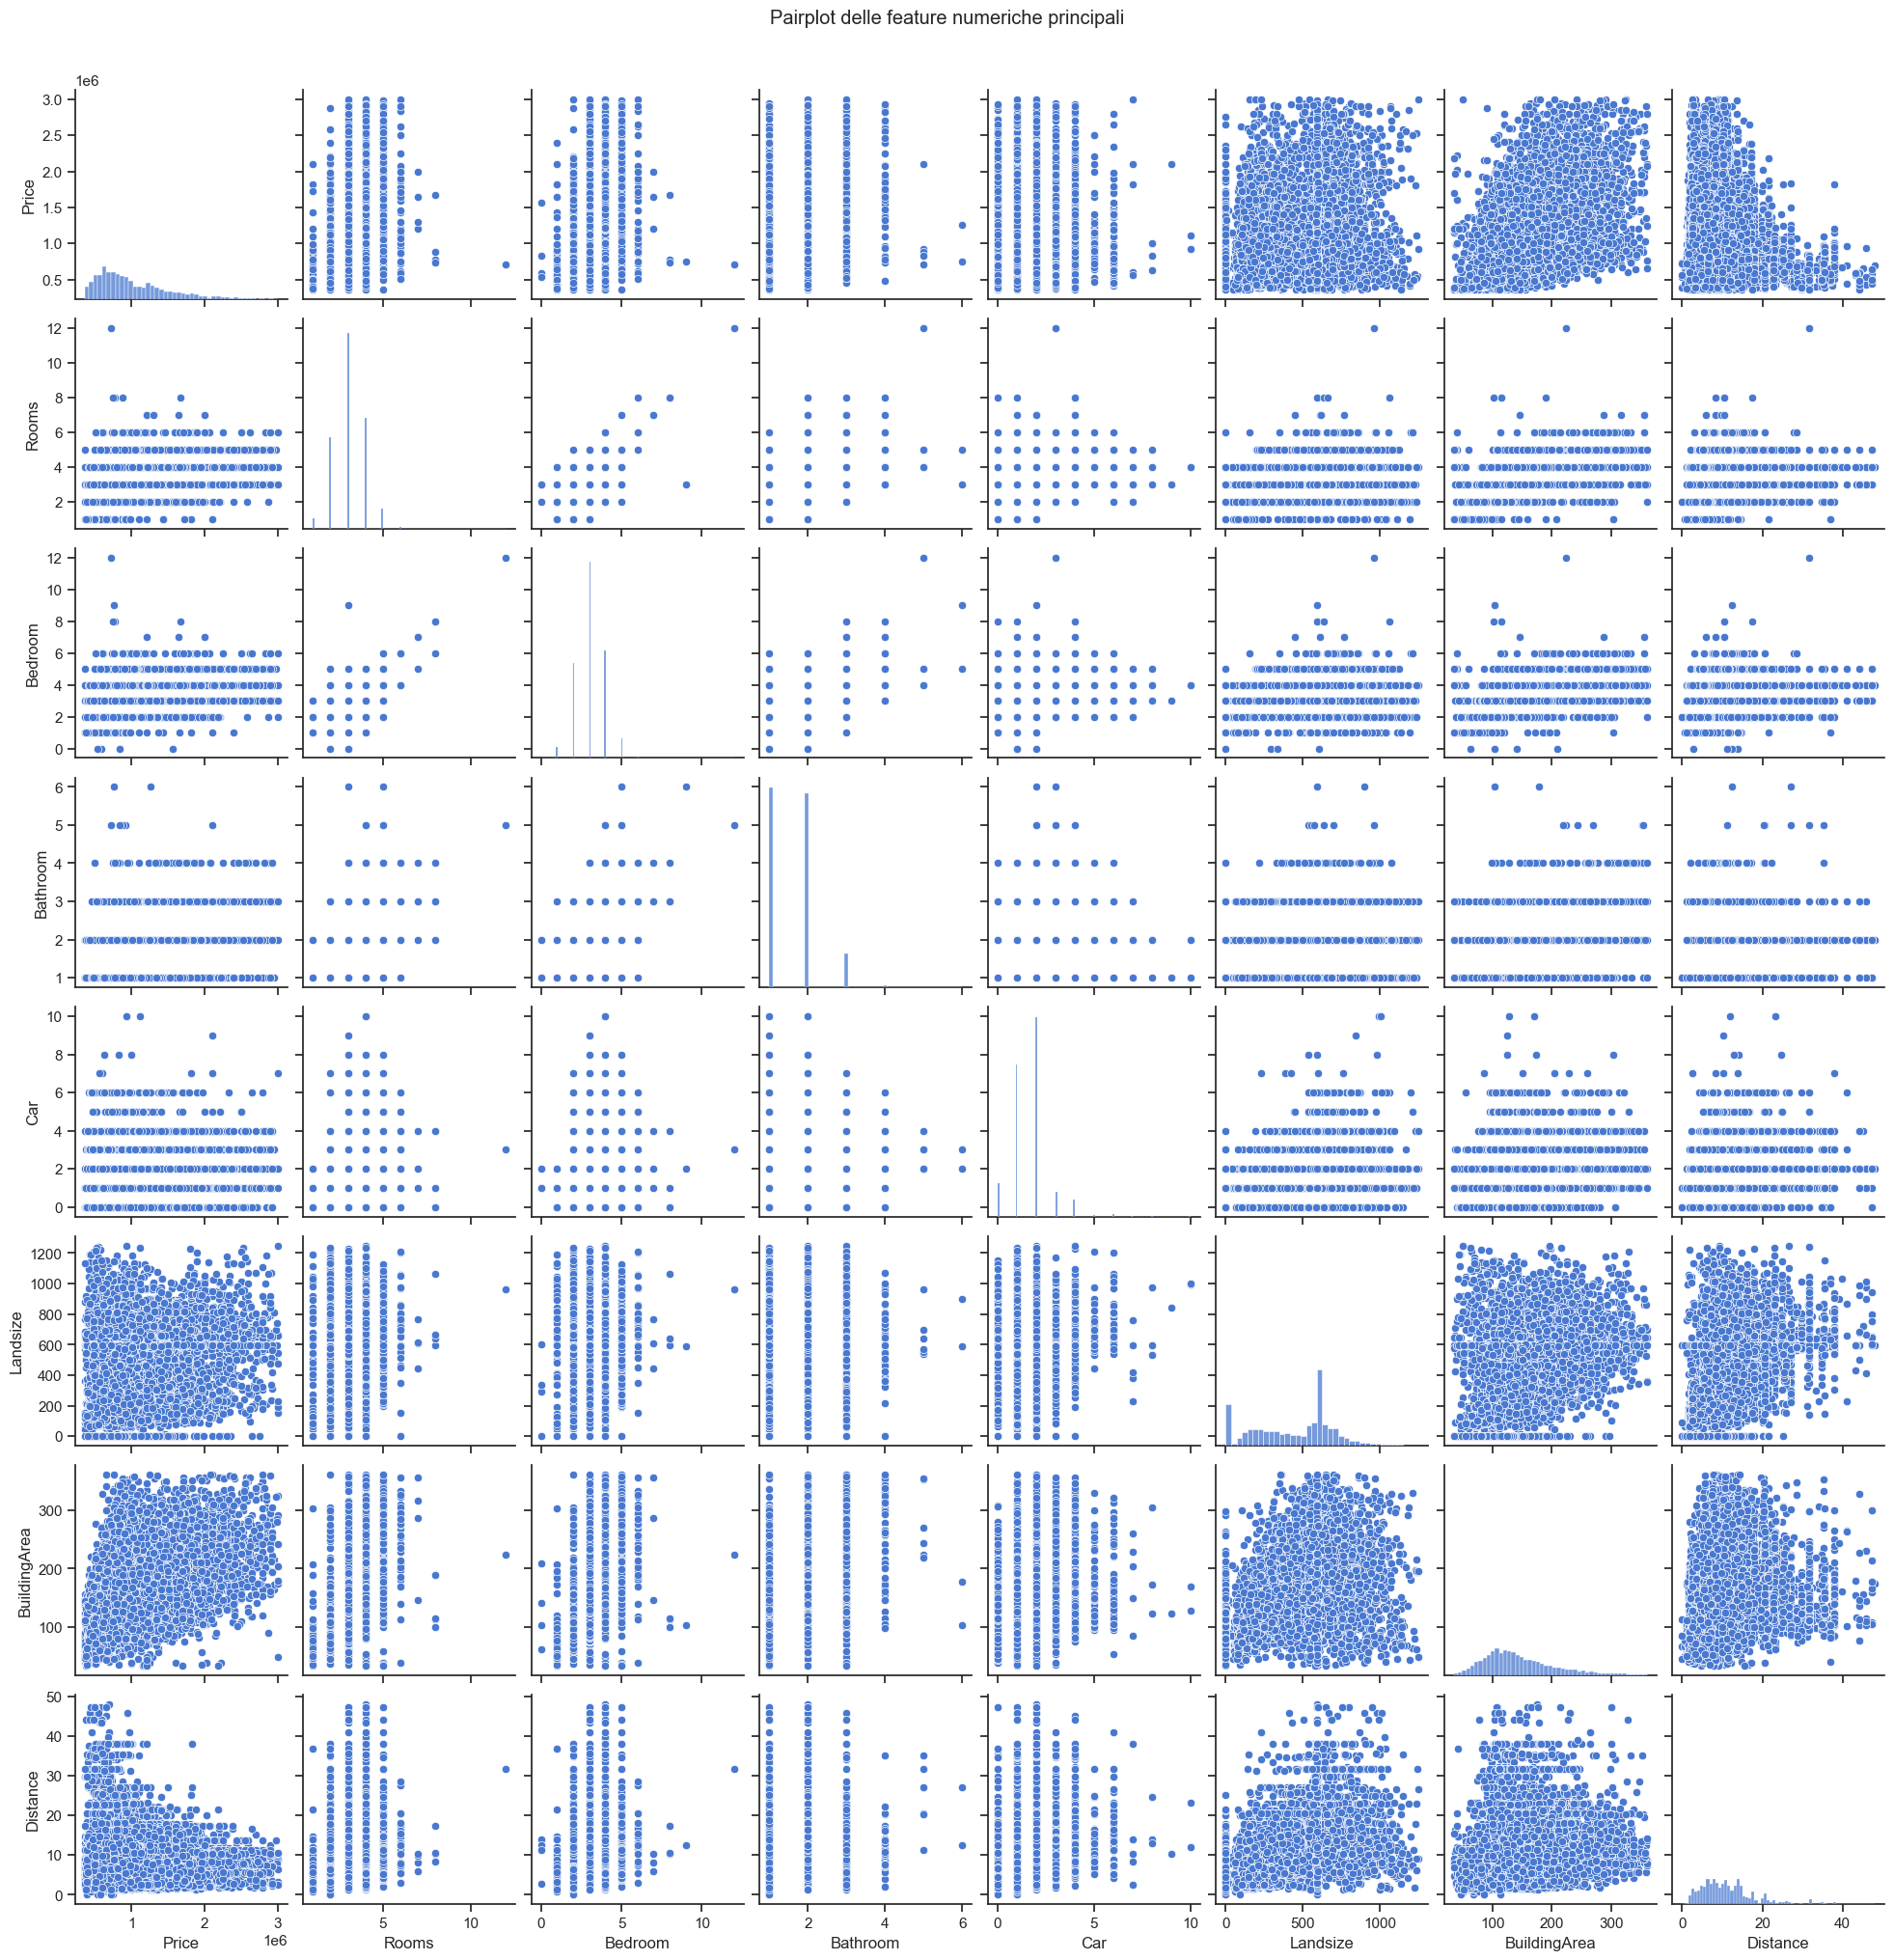

In [14]:
# pairplot 
num_cols = ['Price', 'Rooms', 'Bedroom', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Distance']

# 🔹 Creazione del pairplot
sns.set(style="ticks", palette="muted")
plt.figure(figsize=(12,12))
sns.pairplot(df[num_cols])
plt.suptitle("Pairplot delle feature numeriche principali", y=1.02)
plt.show()


In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modelli lineari (Ridge, Lasso, ElasticNet)

In [16]:
# LassoCV (L1) con CV e alpha ottimizzato
lasso_model = LassoCV(alphas=np.logspace(-3,2,20), cv=5, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)

y_pred_lasso = lasso_model.predict(X_test_scaled)

In [17]:
# 🔹 RidgeCV (L2) con CV
ridge_model = RidgeCV(alphas=np.logspace(-2,2,20), cv=5)
ridge_model.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_model.predict(X_test_scaled)

In [18]:
elastic = ElasticNetCV(
    l1_ratio=np.linspace(0.1,0.9,9),
    alphas=np.logspace(-3,2,20),
    cv=5,
    max_iter=10000,
    random_state=42
)
elastic.fit(X_train_scaled, y_train)
y_pred_elastic = elastic.predict(X_test_scaled)

## Modelli non lineari (RandomForest, XGBoost)

In [19]:
rf = RandomForestRegressor(n_estimators=500, max_depth=15, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    verbosity=0
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


## K-FOLD

In [20]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

ridge_cv = -cross_val_score(ridge_model, X_train_scaled, y_train, cv=cv, scoring="neg_root_mean_squared_error")
lasso_cv = -cross_val_score(lasso_model, X_train_scaled, y_train, cv=cv, scoring="neg_root_mean_squared_error")
elastic_cv = -cross_val_score(elastic, X_train_scaled, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\n=== Cross-Validation (RMSE – 5 folds) ===")
print(f"Ridge      → mean: {ridge_cv.mean():.4f} | std: {ridge_cv.std():.4f}")
print(f"Lasso      → mean: {lasso_cv.mean():.4f} | std: {lasso_cv.std():.4f}")
print(f"ElasticNet → mean: {elastic_cv.mean():.4f} | std: {elastic_cv.std():.4f}")

print("\n=== Cross-Validation (R² – 5 folds) ===")
print(f"Ridge      → mean: {ridge_cv.mean():.4f} | std: {ridge_cv.std():.4f}")
print(f"Lasso      → mean: {lasso_cv.mean():.4f} | std: {lasso_cv.std():.4f}")
print(f"ElasticNet → mean: {elastic_cv.mean():.4f} | std: {elastic_cv.std():.4f}")


=== Cross-Validation (RMSE – 5 folds) ===
Ridge      → mean: 0.1985 | std: 0.0024
Lasso      → mean: 0.1998 | std: 0.0021
ElasticNet → mean: 0.1985 | std: 0.0023

=== Cross-Validation (R² – 5 folds) ===
Ridge      → mean: 0.1985 | std: 0.0024
Lasso      → mean: 0.1998 | std: 0.0021
ElasticNet → mean: 0.1985 | std: 0.0023


In [21]:
# valutazione 
results = {}

models = {
    "Ridge": (ridge_model, y_pred_ridge),
    "Lasso": (lasso_model, y_pred_lasso),
    "ElasticNet": (elastic, y_pred_elastic),
    "RandomForest": (rf, y_pred_rf),
    "XGBoost": (xgb, y_pred_xgb)
}

for name, (model, y_pred) in models.items():
    r2 = model.score(X_test_scaled, y_test) if name in ["Ridge","Lasso","ElasticNet"] else model.score(X_test, y_test)
    rmse, mae = eval_preds(y_test, y_pred)
    results[name] = {"R2": r2, "RMSE": rmse, "MAE": mae}

print("\n=== RISULTATI FINALI ===")
for name, m in results.items():
    print(f"{name}: R² = {m['R2']:.4f}, RMSE = {m['RMSE']:.2f}, MAE = {m['MAE']:.2f}")


=== RISULTATI FINALI ===
Ridge: R² = 0.8310, RMSE = 237104.38, MAE = 162332.90
Lasso: R² = 0.8281, RMSE = 239142.91, MAE = 164198.26
ElasticNet: R² = 0.8307, RMSE = 237370.39, MAE = 162569.73
RandomForest: R² = 0.8579, RMSE = 218988.35, MAE = 147852.72
XGBoost: R² = 0.8799, RMSE = 203527.52, MAE = 138000.62


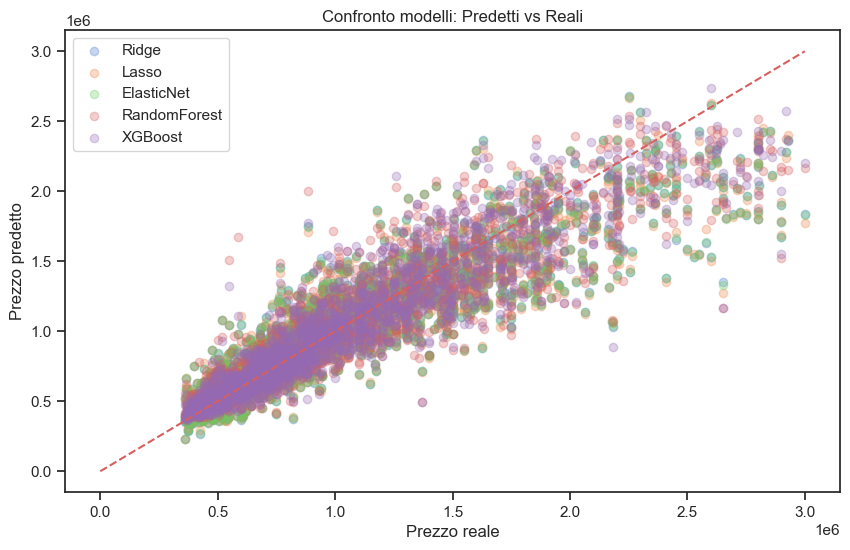

In [22]:
plt.figure(figsize=(10,6))
y_test_real = np.expm1(y_test)

for name, (_, y_pred) in models.items():
    plt.scatter(y_test_real, np.expm1(y_pred), alpha=0.3, label=name)

plt.plot([0, max(y_test_real)], [0, max(y_test_real)], "r--")
plt.xlabel("Prezzo reale")
plt.ylabel("Prezzo predetto")
plt.title("Confronto modelli: Predetti vs Reali")
plt.legend()
plt.show()
